In [2]:
from onetwogo import Params
from onetwogo.parallel_simulation import ParallelSimulation
from onetwogo.experiment_simulation import ExperimentSimulation
from onetwogo.plot import SimulationPlot
from onetwogo.plot import BehavioralPlot

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pickle

%load_ext autoreload
%autoreload 2

In [3]:
PARAMS_DICT = {'Wui': 6,
              'Wuv': 6,
              'Wvi': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'th': 0.65,
              'IF': 50,
              'uinit': 0.7,
              'vinit': 0.2,
              'yinit': 0.5,
               'Iinit': 0.8,
              'first_duration': 750, 
              'sigma': 0.01, 
              'ntrials': 500,
              'delay': 500}

# Stimulus List

In [19]:
params = Params(ntrials=500)
expsim = ExperimentSimulation(params)

stimulus_range_s = [400, 450, 500, 550, 600, 650, 700]
stimulus_range_l = [700, 750, 800, 850, 900, 950, 1000]

stimulus_lst_short = expsim.find_stimulus_lst(stimulus_range_s, 20, 0.9)# ,'stimlst_short_400_700_7_a', True)
stimulus_lst_long = expsim.find_stimulus_lst(stimulus_range_l, 20, 0.9) #, 'stimlst_long_700_1000_7_a', True)

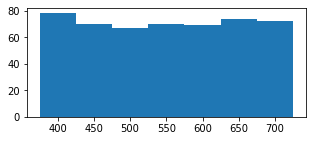

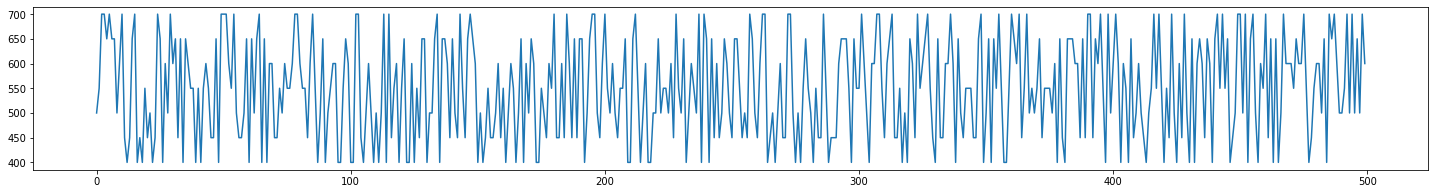

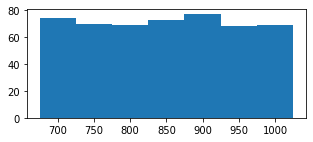

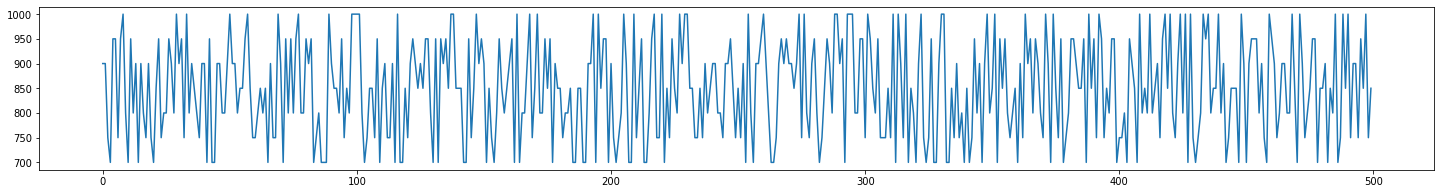

In [15]:
# window 20, 90 %
stimulus_lst_short = np.loadtxt('stimlst_short_400_700_7_a.txt', dtype=int)
stimulus_lst_long = np.loadtxt('stimlst_long_700_1000_7_a.txt', dtype=int)

plt.figure(figsize=(5, 2))
plt.hist(stimulus_lst_short, bins=7,  range=(stimulus_lst_short.min()-25, stimulus_lst_short.max()+25))
plt.show()
plt.figure(figsize=(25, 3))
plt.plot(stimulus_lst_short)

plt.figure(figsize=(5, 2))
plt.hist(stimulus_lst_long, bins=7,  range=(stimulus_lst_long.min()-25, stimulus_lst_long.max()+25))
plt.show()
plt.figure(figsize=(25, 3))
plt.plot(stimulus_lst_long)

# Functions

In [4]:
def load_data(short_path, long_path):
    short_data = []
    long_data = []
    with open(short_path, 'rb') as short:
        with open(long_path, 'rb') as long:
            try:
                while True:
                    short_data.append(pickle.load(short))
                    long_data.append(pickle.load(long))
            except EOFError:
                pass
    return short_data, long_data

In [5]:
# p = K, th, tau, delay
def to_matrix(result_lst, p1, p2, result):
    matrix = np.zeros((p1,p2))
    for i in range(len(result_lst)):
        matrix.flat[i] = result_lst[i][result]
    return matrix

In [6]:
def create_parameter_plot(short, long, shortlong, p1, p1_lst, p2, p2_lst, cmap, n_colors=20, norm=False):
    cmap = sns.color_palette(cmap, n_colors=n_colors)
    minmin = np.min([np.nanmin(short), np.nanmin(long), np.nanmin(shortlong)])
    maxmax = np.max([np.nanmax(short), np.nanmax(long), np.nanmax(shortlong)])
    
    fig, ax = plt.subplots(1,3, figsize= (15,4), sharex=True, sharey=True)
    if norm == 'log':
        norm = matplotlib.colors.LogNorm(vmin=minmin, vmax=maxmax)
        
    if not norm:
        h1 = sns.heatmap(short, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[0], cmap = cmap, cbar=True)#,  vmin=minmin, vmax=maxmax)
        h2 = sns.heatmap(long, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[1], cmap = cmap, cbar=True)#,  vmin=minmin, vmax=maxmax)
        h3 = sns.heatmap(shortlong, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[2],  cmap = cmap)#, vmin=minmin, vmax=maxmax) #cbar_ax= cbar_ax,
    else:
        cbar_ax = fig.add_axes([.91, .25, .01, .5]) #x, y, breite, höhe
        h1 = sns.heatmap(short, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[0], cmap = cmap, cbar=False,  vmin=minmin, vmax=maxmax, norm=norm)
        h2 = sns.heatmap(long, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[1], cmap = cmap, cbar=False,  vmin=minmin, vmax=maxmax, norm=norm)
        h3 = sns.heatmap(shortlong, xticklabels=p2_lst, yticklabels=p1_lst, ax=ax[2],  cmap = cmap, cbar_ax= cbar_ax, vmin=minmin, vmax=maxmax, norm=norm)

    h1.set_xlabel(p2)
    h1.set_ylabel(p1)
    h1.set_title('short')

    h2.set_xlabel(p2)
    h2.set_title('long')

    h3.set_xlabel(p2)
    h3.set_title('short~long')
    
    plt.show()

In [7]:
def plot_slope(short, long):
    short_ktau_slope = to_matrix(short, len(K_lst), len(tau), 'slope')
    long_ktau_slope = to_matrix(long, len(K_lst), len(tau), 'slope')
    divnorm=matplotlib.colors.TwoSlopeNorm(vcenter=0)
    create_parameter_plot(short_ktau_slope, long_ktau_slope, short_ktau_slope-long_ktau_slope, 'K', K_lst, 'tau', tau, 'coolwarm', norm=divnorm)
    plt.show()
    
def plot_mse(short, long):
    short_ktau_bias2 = to_matrix(short, len(K_lst), len(tau), 'bias2')
    short_ktau_var = to_matrix(short, len(K_lst), len(tau), 'var')
    long_ktau_bias2 = to_matrix(long, len(K_lst), len(tau), 'bias2')
    long_ktau_var = to_matrix(long, len(K_lst), len(tau), 'var')
    short_mse = short_ktau_bias2+short_ktau_var
    long_mse = long_ktau_bias2+long_ktau_var
    create_parameter_plot(short_mse, long_mse, (short_mse+long_mse)/2, 'K', K_lst, 'tau', tau, 'gray', n_colors=50, norm = 'log')
    plt.show()

def plot_mse_total(short, long):
    short_ktau_mse = to_matrix(short, len(K_lst), len(tau), 'MSE')
    long_ktau_mse = to_matrix(long, len(K_lst), len(tau), 'MSE')
    create_parameter_plot(short_ktau_mse, long_ktau_mse, (short_ktau_mse+long_ktau_mse)/2, 'K', K_lst, 'tau', tau, 'gray', n_colors=50)
    plt.show()

# Parameter Space

In [8]:
K_lst = np.arange(0.5, 10.5, 0.5)
th_lst = np.arange(0.6, 0.75, 0.01)
delay_lst = np.arange(400, 1000, 50)
tau = np.arange(60, 200, 10)

print(len(K_lst), len(th_lst), len(delay_lst), len(tau))

20 16 12 14


In [25]:
def create_search_space(srange, K_lst, th_lst, tau, delay_lst):
    search_space = []

    if srange == 'short':
        stimulus_range = [400, 450, 500, 550, 600, 650, 700]
    if srange == 'long':
        stimulus_range = [700, 750, 800, 850, 900, 950, 1000]
    if K_lst== True:
        K_lst = np.arange(0.5, 10.5, 0.5)
    if th_lst== True:
        th_lst = np.arange(0.6, 0.75, 0.01)
    if delay_lst== True:
        delay_lst = np.arange(400, 1000, 50)
    if tau== True:
        tau = np.arange(60, 200, 10)
    
    i = 0
    for K in K_lst:
        for th in th_lst:
            for t in tau:
                for delay in delay_lst:
                    i += 1
                    search_space.append((stimulus_range, K, th, t, delay))
    print(i)
    return search_space

In [35]:
srange = 'short'
K_lst = True
th_lst = [0.7]
tau = True
delay_lst = [700]

search_space = create_search_space(srange, K_lst, th_lst, tau, delay_lst)

280


In [9]:
short_stat, long_stat = load_data('../results/SHORT_SAME_K8_TAU100_TH08_DEL700-20220526-125612-output.pickle',
                                  '../results/LONG_SAME_K8_TAU100_TH08_DEL700-20220526-150912-output.pickle')
short_stat_n, long_stat_n = load_data('../results/SHORT_SAME_NOISE_K8_TAU100_TH08_DEL700-20220527-155508-output.pickle',
                                  '../results/LONG_SAME_NOISE_K8_TAU100_TH08_DEL700-20220527-160455-output.pickle')
short_var, long_var = load_data('../results/SHORT_K8_TAU100_TH08_DEL700-20220526-170830-output.pickle',
                                  '../results/LONG_K8_TAU100_TH08_DEL700-20220526-165306-output.pickle')

In [58]:
slope_short, slope_long, ind_short, ind_long, mse_short, mse_long= [], [], [], [], [], []

for i in range(len(short_stat)):
    slope_short.append(short_stat[i]['slope'])
    slope_long.append(long_stat[i]['slope'])
    ind_short.append(short_stat[i]['ind_point'])
    ind_long.append(long_stat[i]['ind_point'])
    mse_short.append(short_stat[i]['bias2']+short_stat[i]['var'])
    mse_long.append(long_stat[i]['bias2']+long_stat[i]['var'])

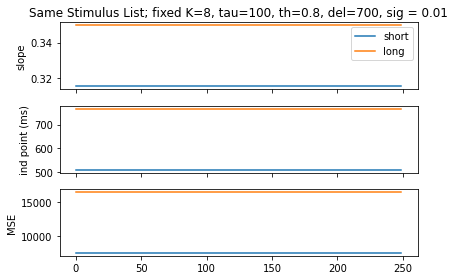

In [59]:
fig, axs = plt.subplots(3,1, sharex=True)

axs[0].plot(slope_short, label='short')
axs[0].plot(slope_long, label='long')
axs[0].set_ylabel('slope')
axs[0].legend()
axs[0].set_title('Same Stimulus List; fixed K=8, tau=100, th=0.8, del=700, sig = 0.01')

axs[1].plot(ind_short)
axs[1].plot(ind_long)
axs[1].set_ylabel('ind point (ms)')

axs[2].plot(mse_short)
axs[2].plot(mse_long)
axs[2].set_ylabel('MSE')

plt.tight_layout()

In [60]:
slope_short, slope_long, ind_short, ind_long, mse_short, mse_long= [], [], [], [], [], []

for i in range(len(short_stat_n)):
    slope_short.append(short_stat_n[i]['slope'])
    slope_long.append(long_stat_n[i]['slope'])
    ind_short.append(short_stat_n[i]['ind_point'])
    ind_long.append(long_stat_n[i]['ind_point'])
    mse_short.append(short_stat_n[i]['bias2']+short_stat_n[i]['var'])
    mse_long.append(long_stat_n[i]['bias2']+long_stat_n[i]['var'])

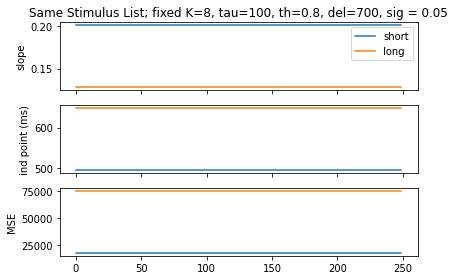

In [61]:
fig, axs = plt.subplots(3,1, sharex=True)

axs[0].plot(slope_short, label='short')
axs[0].plot(slope_long, label='long')
axs[0].set_ylabel('slope')
axs[0].legend()
axs[0].set_title('Same Stimulus List; fixed K=8, tau=100, th=0.8, del=700, sig = 0.05')

axs[1].plot(ind_short)
axs[1].plot(ind_long)
axs[1].set_ylabel('ind point (ms)')

axs[2].plot(mse_short)
axs[2].plot(mse_long)
axs[2].set_ylabel('MSE')

plt.tight_layout()

In [55]:
slope_short, slope_long, ind_short, ind_long, mse_short, mse_long= [], [], [], [], [], []

for i in range(len(short_var)):
    slope_short.append(short_var[i]['slope'])
    slope_long.append(long_var[i]['slope'])
    ind_short.append(short_var[i]['ind_point'])
    ind_long.append(long_var[i]['ind_point'])
    mse_short.append(short_var[i]['bias2']+short_var[i]['var'])
    mse_long.append(long_var[i]['bias2']+long_var[i]['var'])

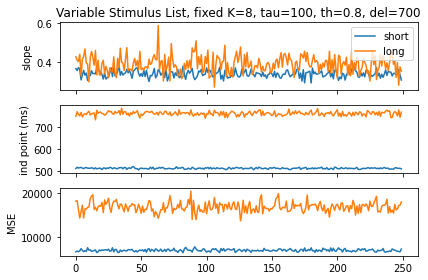

In [56]:
fig, axs = plt.subplots(3,1, sharex=True)

axs[0].plot(slope_short, label='short')
axs[0].plot(slope_long, label='long')
axs[0].set_ylabel('slope')
axs[0].legend()
axs[0].set_title('Variable Stimulus List, fixed K=8, tau=100, th=0.8, del=700')

axs[1].plot(ind_short)
axs[1].plot(ind_long)
axs[1].set_ylabel('ind point (ms)')

axs[2].plot(mse_short)
axs[2].plot(mse_long)
axs[2].set_ylabel('MSE')

plt.tight_layout()

In [30]:
path = '../results/'
short_ktau07, long_ktau07 = load_data(path+'SHORT_KTAU_th07_del700-20220526-155150-output.pickle', 
                                      path+'LONG_KTAU_th07_del700-20220526-160145-output.pickle')
short_ktau06, long_ktau06 = load_data(path+'SHORT_KTAU_th06_del700-20220526-152721-output.pickle',
                                      path+'LONG_KTAU_th06_del700-20220526-153708-output.pickle')
short_ktau08, long_ktau08 = load_data(path+'SHORT_KTAU_th08_del700-20220526-162047-output.pickle', 
                                      path+'LONG_KTAU_th07_del700-20220526-160145-output.pickle')

th 06 short&long: 
overflow encountered in exp return 1 / (1 + np.exp(-x)) \
executing with K=9/10 tau=70-170

threshold 0.8


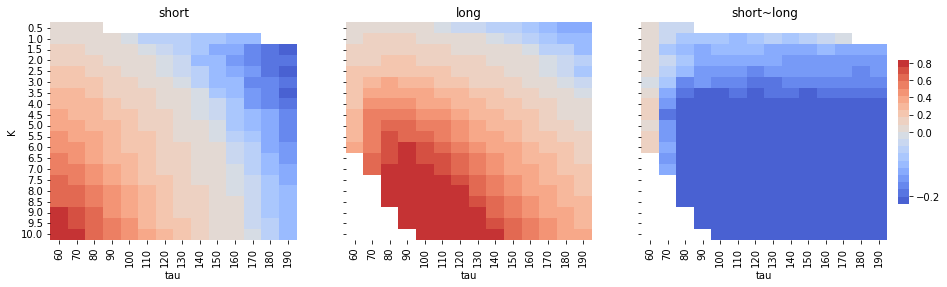

threshold 0.7


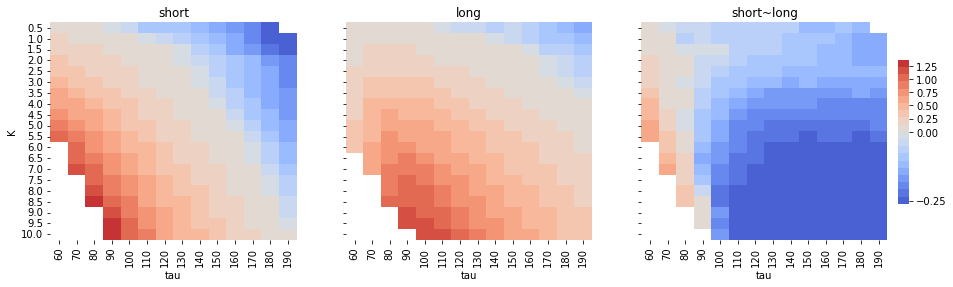

threshold 0.6


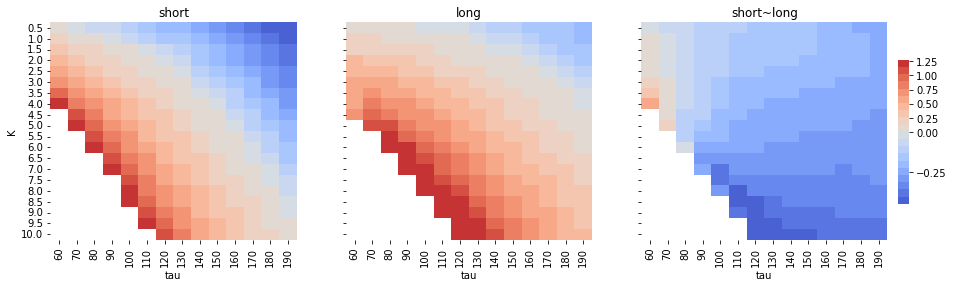

In [31]:
print('threshold', 0.8)
plot_slope(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_slope(short_ktau07, long_ktau07)
print('threshold', 0.6)
plot_slope(short_ktau06, long_ktau06)

threshold 0.8


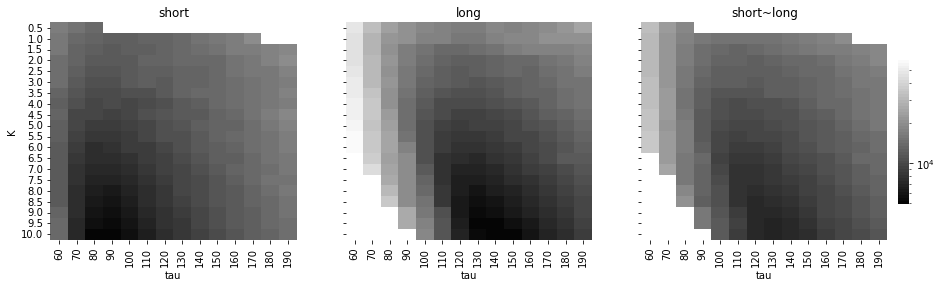

threshold 0.7


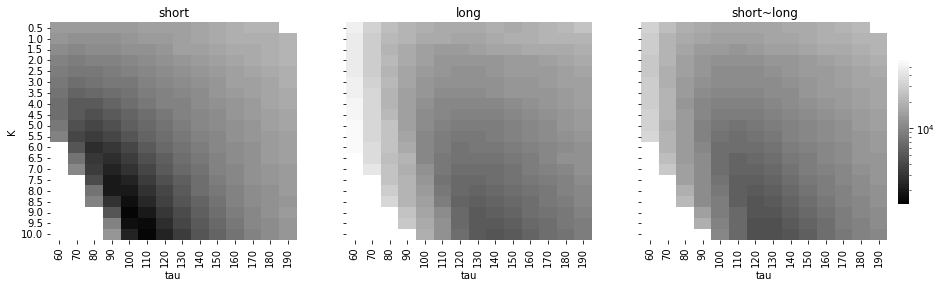

threshold 0.6


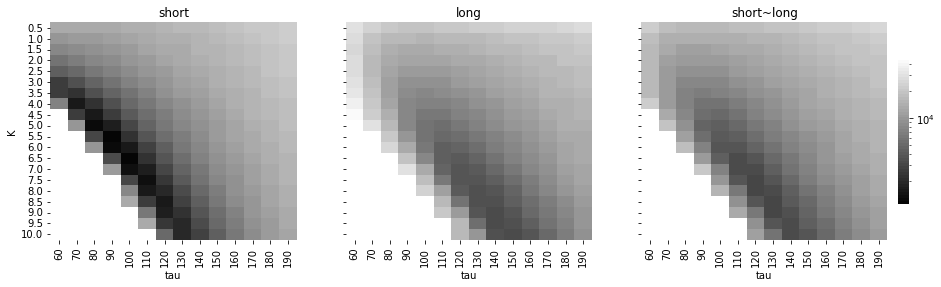

In [44]:
print('threshold', 0.8)
plot_mse(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_mse(short_ktau07, long_ktau07)
print('threshold', 0.6)
plot_mse(short_ktau06, long_ktau06)

threshold 0.8


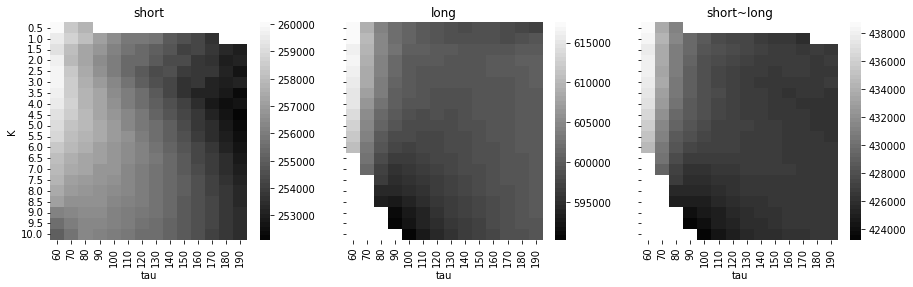

threshold 0.7


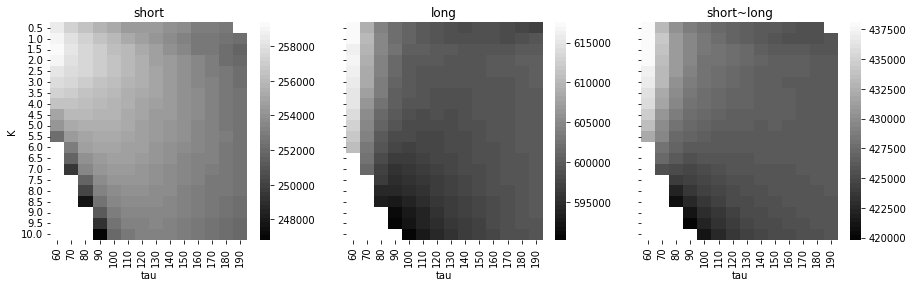

threshold 0.6


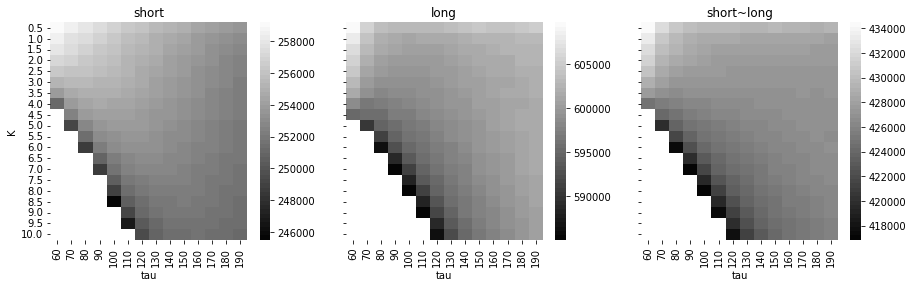

In [33]:
print('threshold', 0.8)
plot_mse_total(short_ktau08, long_ktau08)
print('threshold', 0.7)
plot_mse_total(short_ktau07, long_ktau07)
print('threshold', 0.6)
plot_mse_total(short_ktau06, long_ktau06)

late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
[0]
n=1: late timeout early crossing, n>1: early timeout
late timeout no crossing
late timeout no crossing
late timeout no crossing
[0]
n=1: late timeout early crossing, n>1: early timeout
[0]
n=1: late timeout early crossing, n>1: early timeout
[0]
n=1: late timeout early crossing, n>1: early timeout
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossing
late timeout no crossi

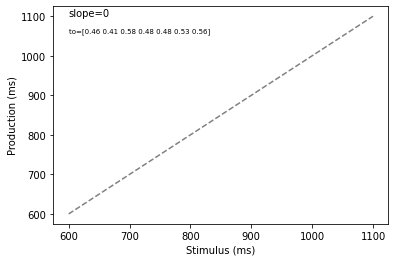

In [47]:
params = Params(ntrials=500, th=0.7, tau=60, delay=700, sigma=0.01)
expsim = ExperimentSimulation(params)

stimulus_range = [700, 750, 800, 850, 900, 950, 1000]
stimulus_lst = expsim.generate_stimulus_lst(stimulus_range)
K = 10.0

exp_result = expsim.simulate(stimulus_lst, K)
beh_result = exp_result.create_behavioral_data()
plot = exp_result.create_behavioral_plot()
#plot = BehavioralPlot(exp_result.crate_behavioral_plot_data())
plot.plot_behavior()